# Sunny Side Sketch Challenge Problem

<img src="https://i.ibb.co/MknQ67tW/eggs.png" width="100%" style="max-width: 600px; display:block; margin:auto;">


Once upon a time, an ambitious engineer was tasked with inventing an “egg-maker” — a marvelous machine that could whip up eggs in all their delicious forms: fried, scrambled, poached, you name it. But somewhere along the way, wires got crossed (literally), and instead of producing eggs, the machine started… drawing them. Perfectly neat outlines of every egg recipe you could imagine appeared on paper, but not a single breakfast was served.
And so, the legend of the “Egg-Maker-That-Only-Makes-Egg-DRAWINGS” was born.

Your task: Design 2D planar linkage mechanisms that can trace six target egg-paths. These curves are your recipes — now go cook up some mechanisms!



We have given you the outlines of eggs we want in a numpy file called `target_curves.npy` which you can load using numpy and plot using matplotlib:

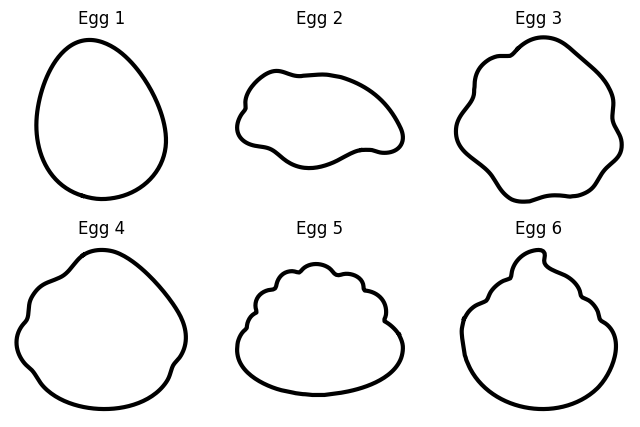

In [98]:
import numpy as np
import matplotlib.pyplot as plt

target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')

## Mechanism Representation

Here we will briefly discuss how we can represent linkage mechanisms. In this demonstration we will represent linkage mechanisms as graphs. A graph is represented as a set of nodes (e.g., $N = \{1,2,3,\ldots,N\}$), and set of edges, that describe how nodes are connected to each other (e.g., $E=\{(1,2), (5,2), \ldots \}$). Graphs can also include features associated with each node (e.g., initial positions of joints in our example of mechanisms).

To see how this works take the mechanism below:

<div width="100%"><img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Path Synthesis Problem" width="40%" style="margin:auto;display:block"></div>


We can see that we have 5 joints, which we will represent as 5 nodes, $N=\{0,1,2,3,4\}$, and we can represent the linkages as edges in the graph, which give us the edges $E=\{(0,2),(1,3),(2,3),(2,4),(3,4)\}$. Note that edges in this graph do not have directions so $(0,2)$ and $(2,0)$ are identical. To keep things neat so we put the smaller index first. Besides the basic graph describing the mechanisms structure, we also see that all nodes have an initial position in 2D space. Nodes $0$ and $1$ are fixed and will remain in place, while the others will move. We will describe these as node features. This means each node will have a 2D initial position and a binary feature describing whether it is fixed or not. We can also see that one of the linkages is highlighed yellow. This is the linkage that is rotated by the actuator. We will also store this information.

In practice the above description boils down to a few (Design) variables in python which we use to describe the mechanism:

- **Initial Positions** `x0`: A 2D array of size $N \times 2$, holding the initial positions of the $N$ joints in the mechanism.
- **Linkages** `edges`: A 2D array of ***integer*** pairs, with shape $E \times 2$ holding the pairs of node indecies from two nodes that are connected to each other by an edge.
- **Fixed Joints** `fixed_joints`: A list of node indices that are fixed.
- **Motor** `motor`: A tuple of integers, which is equivalent to the pair of node indices associated with the actuated edge.

This representation is fine, however sometimes instead of explicitly specifying edges a different approach is used to describe graph connectivity. The so called <b>Adjacency/Connectivity Matrix</b> is another way to represent the edges of a graph. A linkage mechanisms structure can therefore be represented using a matrix of connectivity ($C$), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" width="100%" style="max-width: 700px; display:block; margin:auto;" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected with an edge we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected. We will use this kind of representation in the advanced starter notebook to show how this can help us define a problem for GA that generates the structure of the mechanism as well.

## Instructions


[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Distance: </b>Any mechanisms output with a distance to the target curve larger than 0.75 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 10.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 joints </li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.

Your performance on the targets will be measured based on the hypervolume calculated from the population with a reference point of 0.75 for distance and 10.0 for material use. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all target curves.

## GTA Submission
Now we will run the GA for each target curve seperately and get a full submission going:

In [99]:
import os
# os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random

# deteministic random numbers
np.random.seed(0)
random.seed(0)

from LINKS.CP import make_empty_submission, evaluate_submission
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimization import DifferentiableTools, Tools
from LINKS.Geometry import CurveEngine
from LINKS.Visualization import MechanismVisualizer, GAVisualizer

# pymoo imports
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV


In [100]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_Synthesis_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self, edges, fixed_joints, motor, target_curve):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = x0.shape[0] * 2, n_obj=2, n_constr=2, xl=0.0, xu=5.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.N = x0.shape[0]

        # Store the target
        self.target_curve = target_curve
        
    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                self.edges,
                                self.fixed_joints,
                                self.motor,
                                self.target_curve,
                                target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

In [101]:
target_curves = np.load('target_curves.npy')

solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

curve_processor = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

optimization_tools = Tools(
    device='cpu' # device to run the optimization on
)
optimization_tools.compile() # compile the functions for faster runs

gradient_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)
gradient_tools.compile() # compile the functions for faster runs

In [ ]:
# starter_mech = np.load('starter_mechanism.npy',allow_pickle=True).item() #Load mechanism

# x0 = starter_mech['x0']
# edges = starter_mech['edges']
# fixed_joints = starter_mech['fixed_joints']
# motor = starter_mech['motor']


# Define the variables for the mechanism
x0 = np.array([[0.2,0.1],
               [0.22,0.2],
               [0.62,0.275],
               [0.35,-1.75],
               [0.62,0.15]])

# Define the connectivity of the mechanism
edges = np.array([[0,1],
                  [1,2],
                  [1,3],
                  [2,3],
                  [2,4]])

fixed_joints = np.array([0,4])
motor = np.array([0,1])

In [103]:
# visualizer = MechanismVisualizer()
# plt.figure(figsize=(5,5))
# visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

In [104]:
population_size = 100
num_generations = 50
curves_to_run = [0,1,2,3,4,5]

Optimizing for Problem 1, Please Wait...
Distance to target curve 1: 0.1203
Material used: 4.1919
Distance Gradient:
 [array([12.339133, -2.67349 ], dtype=float32), array([-0.37696037,  0.01493857], dtype=float32), array([-13.1491785,   1.8871549], dtype=float32), array([0.16311377, 0.0297696 ], dtype=float32), array([1.0238912, 0.7416274], dtype=float32)]

Material Gradient:
 [array([-1.9557474 ,  0.41839212], dtype=float32), array([-0.40510827, -1.9585421 ], dtype=float32), array([-1.3451453, -1.5810649], dtype=float32), array([2.817021 , 5.1346564], dtype=float32), array([ 0.8889799, -2.0134416], dtype=float32)]

Optimizing for Problem 2, Please Wait...
Distance to target curve 2: 0.7715
Material used: 3.0953
Distance Gradient:
 [array([-3.0075045, -1.3217402], dtype=float32), array([0.17860238, 0.1475457 ], dtype=float32), array([-1.0534871,  4.283739 ], dtype=float32), array([-3.7050152, -0.7565656], dtype=float32), array([ 7.587404 , -2.3529763], dtype=float32)]

Material Gradien

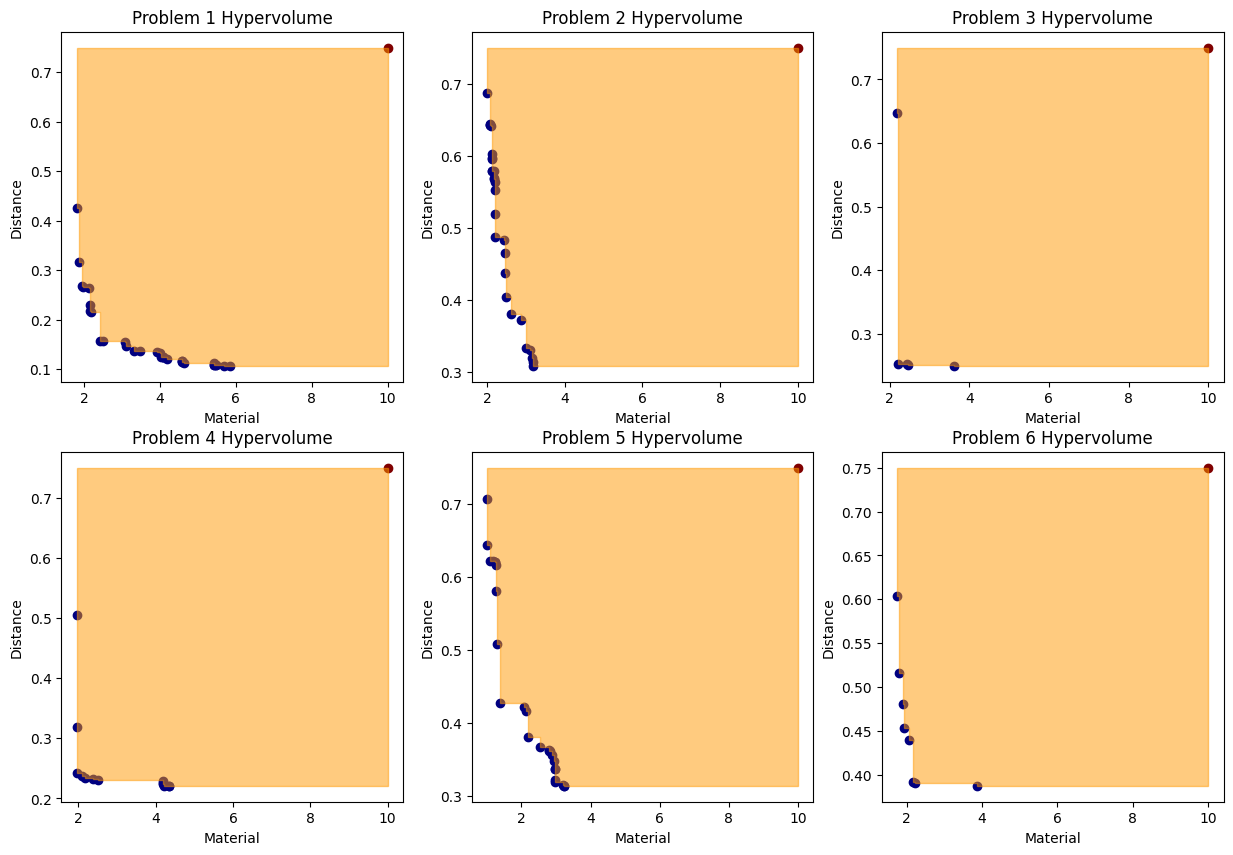

In [105]:
submission = make_empty_submission()
full_results = submission.copy()

for i in curves_to_run:
    
    print(f"Optimizing for Problem {i+1}, Please Wait...")
    
    problem = mechanism_Synthesis_optimization(
        edges,
        fixed_joints,
        motor,
        target_curves[i]
    )
    
    X = x0[None].repeat(population_size, axis=0).reshape(population_size, -1)
    # Setup the algorithm
    algorithm = NSGA2(pop_size=population_size,
                        sampling=X,
                        crossover=SBX(prob=0.5, eta=20.0),
                        mutation=PolynomialMutation(eta=20.0, prob=0.95),
                        eliminate_duplicates=True)

    results = minimize(problem,
                    algorithm,
                    ('n_gen', num_generations),
                    verbose=False,
                    save_history=True,
                    seed=123,
                    )
    
    if results.X is None:
        print('Did Not Find Solutions!!')
    else:
        for j in range(results.X.shape[0]):
            x0_member = results.X[j].reshape(-1,2)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': None # None means it will automatically use the most complex joint (the last joint in our case)
            }

            submission[f'Problem {i+1}'].append(mech)
            full_results[f'Problem {i+1}'] = results
        
        distance, material, distance_grad, material_grad = gradient_tools(x0_member,
                                        edges,
                                        fixed_joints,
                                        motor,
                                        target_curves[0],
                                        target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                                    )
        print(f"Distance to target curve {i+1}: {distance:.4f}")
        print(f"Material used: {material:.4f}")
        print(f"Distance Gradient:\n {distance_grad}\n")
        print(f"Material Gradient:\n {material_grad}\n")


# now let's evaluate the pareto efficient solutions for all problems
ga_visualizer = GAVisualizer()
plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(target_curves)):
    if isinstance(full_results[f'Problem {i+1}'], list) or full_results[f'Problem {i+1}'].X is None:
        print(f'Did Not Find Solutions for Problem {i+1}!!')
        plt.subplot(2, 3, i+1)
        plt.text(0.5, 0.5, 'No Solutions Found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
        continue
    ga_visualizer.plot_HV(
        F=full_results[f'Problem {i+1}'].F,
        ref=np.array([0.75, 10.0]),
        ax=plt.subplot(2, 3, i+1),
        objective_labels=['Distance', 'Material']
    )
    plt.title(f'Problem {i+1} Hypervolume')

In [106]:
scores = evaluate_submission(submission)

overall_score = scores.get('Overall Score', 0)
problem_scores = [scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(scores['Score Breakdown']))]

print(f"Overall Score: {overall_score:.3f}")
print(f"Per Problem Scores: {problem_scores}")

best_submission = np.load('GTA_full_submission.npy', allow_pickle=True).item()
best_scores = evaluate_submission(best_submission)

# Compare and update the best scores if necessary
for i, (current_score, best_score) in enumerate(zip(problem_scores, best_scores['Score Breakdown'].values())):
    if current_score > best_score:
        best_submission[f'Problem {i+1}'] = submission[f'Problem {i+1}']
        print(f"Problem {i} improved! Was: {best_score}")

submission_filename = 'GTA_full_submission.npy'
best_submission['Overall Score'] = np.mean(list(evaluate_submission(best_submission)['Score Breakdown'].values()))
np.save(submission_filename, best_submission)


best_scores = evaluate_submission(best_submission)
b_overall_score = best_scores.get('Overall Score', 0)
b_problem_scores = [best_scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(best_scores['Score Breakdown']))]

print(f"Best Overall Score: {b_overall_score:.3f}")
print(f"Best Per Problem Scores: {b_problem_scores}")

Overall Score: 3.868
Per Problem Scores: [5.097152101877427, 3.373542806134452, 3.890913261555788, 4.229367021145038, 3.676387714670014, 2.942682345884684]
Best Overall Score: 4.830
Best Per Problem Scores: [5.943997052687939, 3.9287469090587734, 4.7752647822574215, 5.348548984842429, 4.44829715850342, 4.534457527573972]


## Leader Board:
You can submit your numpy files to the leaderboard and see how you are doing compared to others. 
The leaderboard can be found at:

[https://design-ai.mit.edu/CP1/](https://design-ai.mit.edu/CP1/)

for Curve 2:

    Score = 4.7643

    pop = 650
    gen = 300

    c = 0.9, 15
    p = 0.9, 15


Finding optimal eta:

    pop = 50
    gen = 25

    c = 0.9
    p = 0.9

    for eta = 10 --> Score = 4.1059
    for eta = 15 --> Score = 4.1360
                                        for eta = 20 --> Score = 4.1675
    for eta = 25 --> Score = 4.1473
    for eta = 30 --> Score = 4.1607
    for eta = 50 --> Score = 4.1601
    
Finding Optimal Crossover Prob

    pop = 50
    gen = 25
    p = 0.9
    eta = 20

    for c = 0.05 --> Score = 4.095
    for c = 0.15 --> Score = 4.1467
    for c = 0.30 --> Score = 4.1477
                                        for c = 0.50 --> Score = 4.1826
    for c = 0.70 --> Score = 4.1693
    for c = 0.85 --> Score = 4.1703
    for c = 0.95 --> Score = 4.1773

Finding Optimal Mutation Prob

    pop = 50
    gen = 25
    c = 0.5
    eta = 20

    for p = 0.05 --> Score = 3.019
    for p = 0.15 --> Score = N/A
    for p = 0.30 --> Score = 4.1477
    for p = 0.50 --> Score = 4.1649
    for p = 0.70 --> Score = 4.1599
    for p = 0.85 --> Score = 4.1430
    for p = 0.90 --> Score = 4.1826
                                        for p = 0.95 --> Score = 4.1896
    for p = 0.99 --> Score = 4.1617


for pop = 500, gen = 200 --> Score = 4.7226
for pop = 1000, gen = 500 --> Score = 4.775


for Curve 1:

    for 5 nodes - for pop = 800, gen = 400 --> Score = 3.9118

    for 6 nodes - for pop = 800, gen = 500 --> Score = 3.8302

## Gradient Descent Optimization on Best GA Mechanisms

Now we'll take the highest scoring mechanism for each curve from the genetic algorithm results and apply gradient descent optimization to further improve them.


In [107]:
# Extract the best mechanism for each curve from GA results
def extract_best_mechanism_per_curve(full_results, target_curves):
    """
    Extract the highest scoring mechanism for each curve from GA results.
    Returns a dictionary with the best mechanism for each curve.
    """
    best_mechanisms = {}
    
    for i in range(len(target_curves)):
        problem_key = f'Problem {i+1}'
        
        if problem_key not in full_results or full_results[problem_key].X is None:
            print(f'No solutions found for {problem_key}')
            continue
            
        # Get the Pareto front results
        F = full_results[problem_key].F  # Objectives: [distance, material]
        X = full_results[problem_key].X  # Design variables
        
        # Find the mechanism with the best combined score
        # We'll use a weighted combination of distance and material
        # Lower distance and material are better, so we want to minimize both
        weights = np.array([1.0, 0.1])  # Weight distance more heavily than material
        combined_scores = np.sum(F * weights, axis=1)
        best_idx = np.argmin(combined_scores)
        
        # Extract the best mechanism
        best_x0 = X[best_idx].reshape(-1, 2)
        best_distance = F[best_idx, 0]
        best_material = F[best_idx, 1]
        
        best_mechanisms[problem_key] = {
            'x0': best_x0,
            'edges': edges,
            'fixed_joints': fixed_joints,
            'motor': motor,
            'target_joint': None,
            'ga_distance': best_distance,
            'ga_material': best_material,
            'ga_score': combined_scores[best_idx]
        }
        
        print(f"{problem_key}: GA Best - Distance: {best_distance:.4f}, Material: {best_material:.4f}, Score: {combined_scores[best_idx]:.4f}")
    
    return best_mechanisms

# Extract best mechanisms
best_mechanisms = extract_best_mechanism_per_curve(full_results, target_curves)


Problem 1: GA Best - Distance: 0.1574, Material: 2.4126, Score: 0.3986
Problem 2: GA Best - Distance: 0.3084, Material: 3.1799, Score: 0.6264
Problem 3: GA Best - Distance: 0.2531, Material: 2.2158, Score: 0.4747
Problem 4: GA Best - Distance: 0.2419, Material: 1.9719, Score: 0.4390
Problem 5: GA Best - Distance: 0.4273, Material: 1.3656, Score: 0.5638
Problem 6: GA Best - Distance: 0.3918, Material: 2.1807, Score: 0.6098


In [108]:
# Gradient Descent Optimization Implementation
def gradient_descent_optimization(x0_init, edges, fixed_joints, motor, target_curve, 
                                 learning_rate=0.01, max_iterations=100, tolerance=1e-6):
    """
    Apply gradient descent optimization to improve a mechanism.
    
    Parameters:
    - x0_init: Initial joint positions
    - edges, fixed_joints, motor: Mechanism structure
    - target_curve: Target curve to optimize for
    - learning_rate: Step size for gradient descent
    - max_iterations: Maximum number of iterations
    - tolerance: Convergence tolerance
    
    Returns:
    - optimized_x0: Optimized joint positions
    - optimization_history: List of (distance, material) tuples during optimization
    """
    
    # Initialize
    x0_current = x0_init.copy()
    optimization_history = []
    
    # Get initial evaluation
    initial_distance, initial_material = optimization_tools(
        x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    optimization_history.append((initial_distance, initial_material))
    
    print(f"Initial: Distance = {initial_distance:.4f}, Material = {initial_material:.4f}")
    
    for iteration in range(max_iterations):
        # Compute gradients
        distance, material, distance_grad, material_grad = gradient_tools(
            x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
        )
        
        # Check for invalid solutions
        if np.isinf(distance) or np.isinf(material):
            print(f"Iteration {iteration}: Invalid solution detected, stopping optimization")
            break
            
        # Combined objective: minimize distance + 0.1 * material
        # Handle the gradient structure properly - gradients are lists of arrays
        combined_grad = []
        for i in range(len(distance_grad)):
            combined_grad.append(distance_grad[i] + 0.1 * material_grad[i])
        
        # Update positions (only for non-fixed joints)
        x0_new = x0_current.copy()
        for i in range(len(x0_current)):
            if i not in fixed_joints:
                x0_new[i] = x0_current[i] - learning_rate * combined_grad[i]
        
        # Evaluate new solution
        try:
            new_distance, new_material = optimization_tools(
                x0_new, edges, fixed_joints, motor, target_curve, target_idx=None
            )
            
            # Check if new solution is valid and better
            if not (np.isinf(new_distance) or np.isinf(new_material)):
                current_score = distance + 0.1 * material
                new_score = new_distance + 0.1 * new_material
                
                if new_score < current_score:
                    x0_current = x0_new
                    optimization_history.append((new_distance, new_material))
                    
                    # Check convergence
                    if abs(current_score - new_score) < tolerance:
                        print(f"Converged at iteration {iteration}")
                        break
                else:
                    # Reduce learning rate if no improvement
                    learning_rate *= 0.9
            else:
                # Reduce learning rate if invalid solution
                learning_rate *= 0.5
                
        except Exception as e:
            print(f"Error at iteration {iteration}: {e}")
            learning_rate *= 0.5
            continue
            
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: Distance = {distance:.4f}, Material = {material:.4f}, LR = {learning_rate:.6f}")
    
    final_distance, final_material = optimization_tools(
        x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    
    print(f"Final: Distance = {final_distance:.4f}, Material = {final_material:.4f}")
    print(f"Improvement: Distance {initial_distance:.4f} -> {final_distance:.4f}, Material {initial_material:.4f} -> {final_material:.4f}")
    
    return x0_current, optimization_history

# Apply gradient descent to all best mechanisms
gradient_descent_results = {}

for problem_key, mechanism in best_mechanisms.items():
    print(f"\n=== Optimizing {problem_key} with Gradient Descent ===")
    
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    optimized_x0, history = gradient_descent_optimization(
        mechanism['x0'], 
        mechanism['edges'], 
        mechanism['fixed_joints'], 
        mechanism['motor'], 
        target_curve,
        learning_rate=0.01,
        max_iterations=50
    )
    
    gradient_descent_results[problem_key] = {
        'x0': optimized_x0,
        'edges': mechanism['edges'],
        'fixed_joints': mechanism['fixed_joints'],
        'motor': mechanism['motor'],
        'target_joint': None,
        'optimization_history': history,
        'ga_distance': mechanism['ga_distance'],
        'ga_material': mechanism['ga_material'],
        'ga_score': mechanism['ga_score']
    }



=== Optimizing Problem 1 with Gradient Descent ===
Initial: Distance = 0.1574, Material = 2.4126
Iteration 0: Distance = 0.1574, Material = 2.4126, LR = 0.005000
Iteration 10: Distance = 0.1574, Material = 2.4126, LR = 0.000969
Iteration 20: Distance = 0.1574, Material = 2.4126, LR = 0.000338
Iteration 30: Distance = 0.1522, Material = 2.4176, LR = 0.000222
Iteration 40: Distance = 0.1495, Material = 2.4172, LR = 0.000222
Final: Distance = 0.1442, Material = 2.4147
Improvement: Distance 0.1574 -> 0.1442, Material 2.4126 -> 2.4147

=== Optimizing Problem 2 with Gradient Descent ===
Initial: Distance = 0.3084, Material = 3.1799
Iteration 0: Distance = 0.3084, Material = 3.1799, LR = 0.009000
Iteration 10: Distance = 0.3101, Material = 3.1584, LR = 0.001937
Iteration 20: Distance = 0.3101, Material = 3.1584, LR = 0.000675
Iteration 30: Distance = 0.2942, Material = 3.1425, LR = 0.000492
Iteration 40: Distance = 0.2916, Material = 3.1198, LR = 0.000492
Final: Distance = 0.2913, Material =

In [109]:
# Display final gradient descent scores for each curve
print("\n" + "="*80)
print("GRADIENT DESCENT OPTIMIZATION RESULTS")
print("="*80)

final_gd_scores = {}

for problem_key, result in gradient_descent_results.items():
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    # Get final gradient descent evaluation
    final_distance, final_material = optimization_tools(
        result['x0'], result['edges'], result['fixed_joints'], 
        result['motor'], target_curve, target_idx=None
    )
    
    # Calculate final score
    final_score = final_distance + 0.1 * final_material
    
    final_gd_scores[problem_key] = {
        'distance': final_distance,
        'material': final_material,
        'score': final_score
    }
    
    print(f"{problem_key}:")
    print(f"  Final Distance: {final_distance:.4f}")
    print(f"  Final Material: {final_material:.4f}")
    print(f"  Final Score: {final_score:.4f}")
    print()

print("="*80)
print("SUMMARY: GRADIENT DESCENT FINAL SCORES")
print("="*80)
print(f"{'Problem':<12} {'Distance':<10} {'Material':<10} {'Score':<10}")
print("-" * 50)

for problem_key, scores in final_gd_scores.items():
    print(f"{problem_key:<12} {scores['distance']:<10.4f} {scores['material']:<10.4f} {scores['score']:<10.4f}")

# Calculate overall average
avg_distance = np.mean([scores['distance'] for scores in final_gd_scores.values()])
avg_material = np.mean([scores['material'] for scores in final_gd_scores.values()])
avg_score = np.mean([scores['score'] for scores in final_gd_scores.values()])

print("-" * 50)
print(f"{'AVERAGE':<12} {avg_distance:<10.4f} {avg_material:<10.4f} {avg_score:<10.4f}")



GRADIENT DESCENT OPTIMIZATION RESULTS
Problem 1:
  Final Distance: 0.1442
  Final Material: 2.4147
  Final Score: 0.3857

Problem 2:
  Final Distance: 0.2913
  Final Material: 3.1015
  Final Score: 0.6014

Problem 3:
  Final Distance: 0.2481
  Final Material: 2.1724
  Final Score: 0.4654

Problem 4:
  Final Distance: 0.2341
  Final Material: 1.9591
  Final Score: 0.4300

Problem 5:
  Final Distance: 0.4214
  Final Material: 1.3644
  Final Score: 0.5578

Problem 6:
  Final Distance: 0.3559
  Final Material: 2.1958
  Final Score: 0.5755

SUMMARY: GRADIENT DESCENT FINAL SCORES
Problem      Distance   Material   Score     
--------------------------------------------------
Problem 1    0.1442     2.4147     0.3857    
Problem 2    0.2913     3.1015     0.6014    
Problem 3    0.2481     2.1724     0.4654    
Problem 4    0.2341     1.9591     0.4300    
Problem 5    0.4214     1.3644     0.5578    
Problem 6    0.3559     2.1958     0.5755    
---------------------------------------------

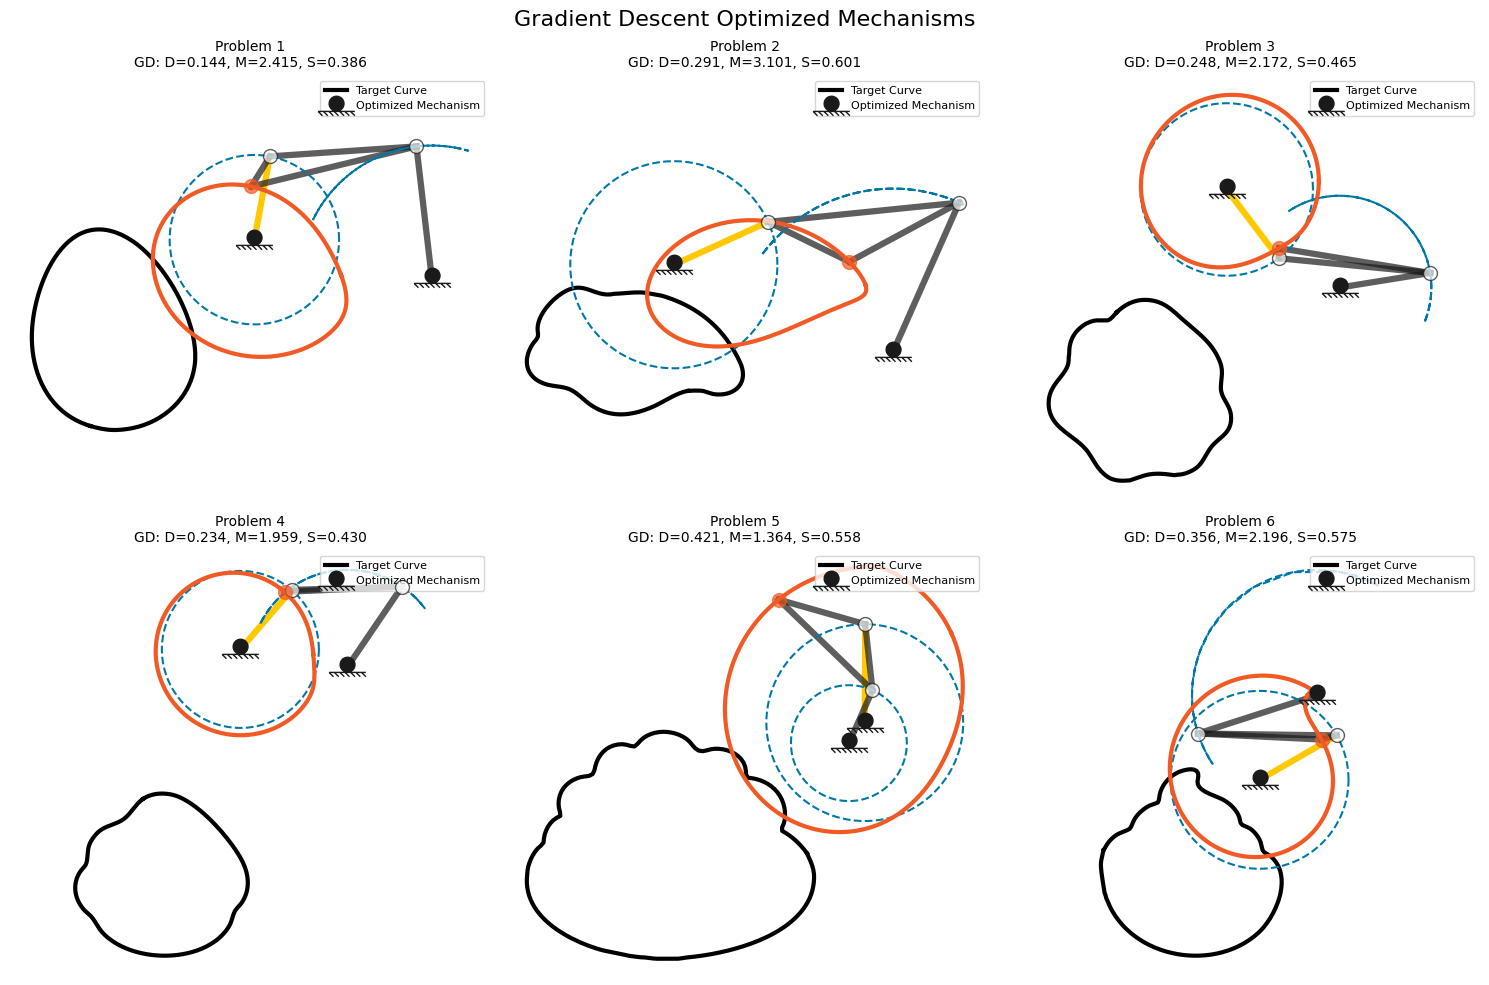

In [110]:
# Visualize the gradient descent optimized mechanisms
def visualize_gradient_descent_results(gradient_descent_results, target_curves):
    """
    Create visualizations showing the gradient descent optimized mechanisms for each curve.
    """
    
    # Create a 2x3 subplot for all curves
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Gradient Descent Optimized Mechanisms', fontsize=16)
    
    visualizer = MechanismVisualizer()
    
    for i, (problem_key, result) in enumerate(gradient_descent_results.items()):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        curve_idx = int(problem_key.split()[1]) - 1
        target_curve = target_curves[curve_idx]
        
        # Plot target curve
        ax.plot(target_curve[:, 0], target_curve[:, 1], 'k-', linewidth=3, label='Target Curve')
        
        # Visualize the gradient descent optimized mechanism
        visualizer(result['x0'], result['edges'], 
                  result['fixed_joints'], result['motor'], ax=ax)
        
        # Get final scores for display
        final_distance, final_material = optimization_tools(
            result['x0'], result['edges'], result['fixed_joints'], 
            result['motor'], target_curve, target_idx=None
        )
        final_score = final_distance + 0.1 * final_material
        
        # Add title with performance info
        title = f'{problem_key}\nGD: D={final_distance:.3f}, M={final_material:.3f}, S={final_score:.3f}'
        ax.set_title(title, fontsize=10)
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
        
        # Add legend
        ax.legend(['Target Curve', 'Optimized Mechanism'], loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_gradient_descent_results(gradient_descent_results, target_curves)


In [111]:
# Create submission with gradient descent optimized mechanisms
def create_gradient_descent_submission(gradient_descent_results):
    """
    Create a submission using the gradient descent optimized mechanisms.
    """
    
    gd_submission = make_empty_submission()
    
    print("\n" + "="*80)
    print("CREATING GRADIENT DESCENT OPTIMIZED SUBMISSION")
    print("="*80)
    
    for problem_key, result in gradient_descent_results.items():
        # Add the gradient descent optimized mechanism to submission
        mechanism = {
            'x0': result['x0'],
            'edges': result['edges'],
            'fixed_joints': result['fixed_joints'],
            'motor': result['motor'],
            'target_joint': None
        }
        
        gd_submission[problem_key].append(mechanism)
        print(f"{problem_key}: Added gradient descent optimized mechanism")
    
    # Evaluate the gradient descent submission
    gd_scores = evaluate_submission(gd_submission)
    gd_overall_score = gd_scores.get('Overall Score', 0)
    gd_problem_scores = [gd_scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(gd_scores['Score Breakdown']))]
    
    print(f"\nGradient Descent Submission Overall Score: {gd_overall_score:.3f}")
    print(f"Gradient Descent Per Problem Scores: {gd_problem_scores}")
    
    return gd_submission, gd_scores

# Create gradient descent submission
gd_submission, gd_scores = create_gradient_descent_submission(gradient_descent_results)

# Save the gradient descent submission
gd_filename = 'GTA_gradient_descent_submission.npy'
np.save(gd_filename, gd_submission)
print(f"\nGradient descent submission saved as: {gd_filename}")



CREATING GRADIENT DESCENT OPTIMIZED SUBMISSION
Problem 1: Added gradient descent optimized mechanism
Problem 2: Added gradient descent optimized mechanism
Problem 3: Added gradient descent optimized mechanism
Problem 4: Added gradient descent optimized mechanism
Problem 5: Added gradient descent optimized mechanism
Problem 6: Added gradient descent optimized mechanism

Gradient Descent Submission Overall Score: 3.625
Gradient Descent Per Problem Scores: [4.595046623519572, 3.164550439859113, 3.9282903045207824, 4.148649679003782, 2.8377174402922094, 3.0757296983222915]

Gradient descent submission saved as: GTA_gradient_descent_submission.npy


In [112]:
# Debug: Check if we're actually getting the best GA mechanisms
print("DEBUGGING: Checking GA mechanism selection and evaluation consistency")
print("="*80)

for problem_key, mechanism in best_mechanisms.items():
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    # Re-evaluate the GA mechanism using the same tools as gradient descent
    ga_distance, ga_material = optimization_tools(
        mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
        mechanism['motor'], target_curve, target_idx=None
    )
    
    # Calculate scores using both methods
    ga_score_method1 = mechanism['ga_score']  # From GA selection
    ga_score_method2 = ga_distance + 0.1 * ga_material  # Same as gradient descent
    
    print(f"\n{problem_key}:")
    print(f"  GA Selection Score: {ga_score_method1:.4f}")
    print(f"  Re-evaluation Score: {ga_score_method2:.4f}")
    print(f"  GA Distance (stored): {mechanism['ga_distance']:.4f}")
    print(f"  GA Distance (re-eval): {ga_distance:.4f}")
    print(f"  GA Material (stored): {mechanism['ga_material']:.4f}")
    print(f"  GA Material (re-eval): {ga_material:.4f}")
    print(f"  Score difference: {abs(ga_score_method1 - ga_score_method2):.6f}")
    
    if abs(ga_score_method1 - ga_score_method2) > 0.001:
        print(f"  ⚠️  WARNING: Score inconsistency detected!")
    else:
        print(f"  ✅ Scores are consistent")


DEBUGGING: Checking GA mechanism selection and evaluation consistency

Problem 1:
  GA Selection Score: 0.3986
  Re-evaluation Score: 0.3986
  GA Distance (stored): 0.1574
  GA Distance (re-eval): 0.1574
  GA Material (stored): 2.4126
  GA Material (re-eval): 2.4126
  Score difference: 0.000000
  ✅ Scores are consistent

Problem 2:
  GA Selection Score: 0.6264
  Re-evaluation Score: 0.6264
  GA Distance (stored): 0.3084
  GA Distance (re-eval): 0.3084
  GA Material (stored): 3.1799
  GA Material (re-eval): 3.1799
  Score difference: 0.000000
  ✅ Scores are consistent

Problem 3:
  GA Selection Score: 0.4747
  Re-evaluation Score: 0.4747
  GA Distance (stored): 0.2531
  GA Distance (re-eval): 0.2531
  GA Material (stored): 2.2158
  GA Material (re-eval): 2.2158
  Score difference: 0.000000
  ✅ Scores are consistent

Problem 4:
  GA Selection Score: 0.4390
  Re-evaluation Score: 0.4390
  GA Distance (stored): 0.2419
  GA Distance (re-eval): 0.2419
  GA Material (stored): 1.9719
  GA Mate

In [113]:
# Debug: Check gradient descent starting point and first few iterations
print("\nDEBUGGING: Checking gradient descent starting point")
print("="*80)

# Let's check just one mechanism in detail
problem_key = list(best_mechanisms.keys())[0]  # Take first problem
mechanism = best_mechanisms[problem_key]
curve_idx = int(problem_key.split()[1]) - 1
target_curve = target_curves[curve_idx]

print(f"Checking {problem_key} in detail:")

# Check initial evaluation
initial_distance, initial_material = optimization_tools(
    mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)
initial_score = initial_distance + 0.1 * initial_material

print(f"  Initial GA mechanism evaluation:")
print(f"    Distance: {initial_distance:.4f}")
print(f"    Material: {initial_material:.4f}")
print(f"    Score: {initial_score:.4f}")

# Check stored GA values
print(f"  Stored GA values:")
print(f"    Distance: {mechanism['ga_distance']:.4f}")
print(f"    Material: {mechanism['ga_material']:.4f}")
print(f"    Score: {mechanism['ga_score']:.4f}")

# Check if they match
if abs(initial_distance - mechanism['ga_distance']) > 0.001:
    print(f"  ⚠️  Distance mismatch!")
if abs(initial_material - mechanism['ga_material']) > 0.001:
    print(f"  ⚠️  Material mismatch!")
if abs(initial_score - mechanism['ga_score']) > 0.001:
    print(f"  ⚠️  Score mismatch!")

# Check gradients
print(f"\n  Checking gradients:")
distance, material, distance_grad, material_grad = gradient_tools(
    mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)

print(f"    Gradient evaluation distance: {distance:.4f}")
print(f"    Gradient evaluation material: {material:.4f}")
print(f"    Distance gradient shape: {[g.shape for g in distance_grad]}")
print(f"    Material gradient shape: {[g.shape for g in material_grad]}")

if abs(distance - initial_distance) > 0.001:
    print(f"    ⚠️  Distance mismatch between tools!")
if abs(material - initial_material) > 0.001:
    print(f"    ⚠️  Material mismatch between tools!")



DEBUGGING: Checking gradient descent starting point
Checking Problem 1 in detail:
  Initial GA mechanism evaluation:
    Distance: 0.1574
    Material: 2.4126
    Score: 0.3986
  Stored GA values:
    Distance: 0.1574
    Material: 2.4126
    Score: 0.3986

  Checking gradients:
    Gradient evaluation distance: 0.1574
    Gradient evaluation material: 2.4126
    Distance gradient shape: [(2,), (2,), (2,), (2,), (2,)]
    Material gradient shape: [(2,), (2,), (2,), (2,), (2,)]


In [114]:
# Fix: Ensure consistent scoring and track best solutions
print("FIXING: Ensuring consistent scoring and tracking best solutions")
print("="*80)

# First, let's check if there's a scoring inconsistency
for problem_key, mechanism in best_mechanisms.items():
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    # Re-evaluate using the same method as gradient descent
    ga_distance, ga_material = optimization_tools(
        mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
        mechanism['motor'], target_curve, target_idx=None
    )
    ga_score = ga_distance + 0.1 * ga_material
    
    print(f"{problem_key}:")
    print(f"  Stored GA score: {mechanism['ga_score']:.4f}")
    print(f"  Re-evaluated GA score: {ga_score:.4f}")
    
    # Update the stored values to be consistent
    mechanism['ga_distance'] = ga_distance
    mechanism['ga_material'] = ga_material
    mechanism['ga_score'] = ga_score

print("\nNow let's run gradient descent with proper best solution tracking...")


FIXING: Ensuring consistent scoring and tracking best solutions
Problem 1:
  Stored GA score: 0.3986
  Re-evaluated GA score: 0.3986
Problem 2:
  Stored GA score: 0.6264
  Re-evaluated GA score: 0.6264
Problem 3:
  Stored GA score: 0.4747
  Re-evaluated GA score: 0.4747
Problem 4:
  Stored GA score: 0.4390
  Re-evaluated GA score: 0.4390
Problem 5:
  Stored GA score: 0.5638
  Re-evaluated GA score: 0.5638
Problem 6:
  Stored GA score: 0.6098
  Re-evaluated GA score: 0.6098

Now let's run gradient descent with proper best solution tracking...


In [115]:
# Improved Gradient Descent with Best Solution Tracking
def improved_gradient_descent_optimization(x0_init, edges, fixed_joints, motor, target_curve, 
                                          learning_rate=0.01, max_iterations=50):
    """
    Apply gradient descent optimization with proper best solution tracking.
    """
    
    # Initialize
    x0_current = x0_init.copy()
    
    # Get initial evaluation
    initial_distance, initial_material = optimization_tools(
        x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    initial_score = initial_distance + 0.1 * initial_material
    
    # Track best solution found so far
    best_x0 = x0_current.copy()
    best_distance = initial_distance
    best_material = initial_material
    best_score = initial_score
    
    print(f"Starting GD: Distance = {initial_distance:.4f}, Material = {initial_material:.4f}, Score = {initial_score:.4f}")
    
    for iteration in range(max_iterations):
        try:
            # Compute gradients
            distance, material, distance_grad, material_grad = gradient_tools(
                x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
            )
            
            # Check for invalid solutions
            if np.isinf(distance) or np.isinf(material):
                print(f"Iteration {iteration}: Invalid solution detected")
                break
                
            # Combined objective: minimize distance + 0.1 * material
            combined_grad = []
            for i in range(len(distance_grad)):
                combined_grad.append(distance_grad[i] + 0.1 * material_grad[i])
            
            # Update positions (only for non-fixed joints)
            x0_new = x0_current.copy()
            for i in range(len(x0_current)):
                if i not in fixed_joints:
                    x0_new[i] = x0_current[i] - learning_rate * combined_grad[i]
            
            # Evaluate new solution
            new_distance, new_material = optimization_tools(
                x0_new, edges, fixed_joints, motor, target_curve, target_idx=None
            )
            
            # Check if new solution is valid
            if not (np.isinf(new_distance) or np.isinf(new_material)):
                new_score = new_distance + 0.1 * new_material
                
                # Only accept if it's better
                if new_score < best_score:
                    x0_current = x0_new
                    best_x0 = x0_new.copy()
                    best_distance = new_distance
                    best_material = new_material
                    best_score = new_score
                    
                    if iteration % 5 == 0:
                        print(f"Iteration {iteration}: Improved! Score = {new_score:.4f}")
                else:
                    # Reduce learning rate if no improvement
                    learning_rate *= 0.9
            else:
                # Reduce learning rate if invalid solution
                learning_rate *= 0.5
                
        except Exception as e:
            print(f"Error at iteration {iteration}: {e}")
            learning_rate *= 0.5
            continue
    
    # Final evaluation of best solution
    final_distance, final_material = optimization_tools(
        best_x0, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    final_score = final_distance + 0.1 * final_material
    
    print(f"Final GD: Distance = {final_distance:.4f}, Material = {final_material:.4f}, Score = {final_score:.4f}")
    
    if final_score < initial_score:
        improvement = initial_score - final_score
        print(f"✅ Improvement: {improvement:.4f}")
    else:
        print(f"⚠️  No improvement found, returning original solution")
        return x0_init, [(initial_distance, initial_material)]
    
    return best_x0, [(initial_distance, initial_material), (final_distance, final_material)]

# Re-run gradient descent with improved function
print("\nRe-running gradient descent with improved tracking...")
improved_gradient_descent_results = {}

for problem_key, mechanism in best_mechanisms.items():
    print(f"\n=== Optimizing {problem_key} with Improved Gradient Descent ===")
    
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    optimized_x0, history = improved_gradient_descent_optimization(
        mechanism['x0'], 
        mechanism['edges'], 
        mechanism['fixed_joints'], 
        mechanism['motor'], 
        target_curve,
        learning_rate=0.01,
        max_iterations=30
    )
    
    improved_gradient_descent_results[problem_key] = {
        'x0': optimized_x0,
        'edges': mechanism['edges'],
        'fixed_joints': mechanism['fixed_joints'],
        'motor': mechanism['motor'],
        'target_joint': None,
        'optimization_history': history,
        'ga_distance': mechanism['ga_distance'],
        'ga_material': mechanism['ga_material'],
        'ga_score': mechanism['ga_score']
    }



Re-running gradient descent with improved tracking...

=== Optimizing Problem 1 with Improved Gradient Descent ===
Starting GD: Distance = 0.1574, Material = 2.4126, Score = 0.3986
Iteration 25: Improved! Score = 0.3955
Final GD: Distance = 0.1522, Material = 2.4176, Score = 0.3940
✅ Improvement: 0.0046

=== Optimizing Problem 2 with Improved Gradient Descent ===
Starting GD: Distance = 0.3084, Material = 3.1799, Score = 0.6264
Iteration 25: Improved! Score = 0.6216
Final GD: Distance = 0.2942, Material = 3.1425, Score = 0.6084
✅ Improvement: 0.0179

=== Optimizing Problem 3 with Improved Gradient Descent ===
Starting GD: Distance = 0.2531, Material = 2.2158, Score = 0.4747
Final GD: Distance = 0.2516, Material = 2.2093, Score = 0.4725
✅ Improvement: 0.0022

=== Optimizing Problem 4 with Improved Gradient Descent ===
Starting GD: Distance = 0.2419, Material = 1.9719, Score = 0.4390
Final GD: Distance = 0.2419, Material = 1.9719, Score = 0.4390
⚠️  No improvement found, returning origi

In [116]:
# Display final improved gradient descent scores
print("\n" + "="*80)
print("IMPROVED GRADIENT DESCENT OPTIMIZATION RESULTS")
print("="*80)

final_improved_gd_scores = {}

for problem_key, result in improved_gradient_descent_results.items():
    curve_idx = int(problem_key.split()[1]) - 1
    target_curve = target_curves[curve_idx]
    
    # Get final gradient descent evaluation
    final_distance, final_material = optimization_tools(
        result['x0'], result['edges'], result['fixed_joints'], 
        result['motor'], target_curve, target_idx=None
    )
    
    # Calculate final score
    final_score = final_distance + 0.1 * final_material
    
    final_improved_gd_scores[problem_key] = {
        'distance': final_distance,
        'material': final_material,
        'score': final_score
    }
    
    print(f"{problem_key}:")
    print(f"  GA Score:     {result['ga_score']:.4f}")
    print(f"  GD Score:     {final_score:.4f}")
    print(f"  Improvement:  {result['ga_score'] - final_score:.4f}")
    print(f"  Final Distance: {final_distance:.4f}")
    print(f"  Final Material: {final_material:.4f}")
    print()

print("="*80)
print("SUMMARY: IMPROVED GRADIENT DESCENT FINAL SCORES")
print("="*80)
print(f"{'Problem':<12} {'GA Score':<10} {'GD Score':<10} {'Improvement':<12} {'Distance':<10} {'Material':<10}")
print("-" * 80)

total_improvement = 0
for problem_key, scores in final_improved_gd_scores.items():
    ga_score = improved_gradient_descent_results[problem_key]['ga_score']
    gd_score = scores['score']
    improvement = ga_score - gd_score
    total_improvement += improvement
    
    print(f"{problem_key:<12} {ga_score:<10.4f} {gd_score:<10.4f} {improvement:<12.4f} {scores['distance']:<10.4f} {scores['material']:<10.4f}")

print("-" * 80)
print(f"{'TOTAL':<12} {'':<10} {'':<10} {total_improvement:<12.4f} {'':<10} {'':<10}")

if total_improvement > 0:
    print(f"\n✅ Gradient descent improved the overall score by {total_improvement:.4f}")
else:
    print(f"\n⚠️  Gradient descent did not improve the overall score")



IMPROVED GRADIENT DESCENT OPTIMIZATION RESULTS
Problem 1:
  GA Score:     0.3986
  GD Score:     0.3940
  Improvement:  0.0046
  Final Distance: 0.1522
  Final Material: 2.4176

Problem 2:
  GA Score:     0.6264
  GD Score:     0.6084
  Improvement:  0.0179
  Final Distance: 0.2942
  Final Material: 3.1425

Problem 3:
  GA Score:     0.4747
  GD Score:     0.4725
  Improvement:  0.0022
  Final Distance: 0.2516
  Final Material: 2.2093

Problem 4:
  GA Score:     0.4390
  GD Score:     0.4390
  Improvement:  0.0000
  Final Distance: 0.2419
  Final Material: 1.9719

Problem 5:
  GA Score:     0.5638
  GD Score:     0.5579
  Improvement:  0.0060
  Final Distance: 0.4215
  Final Material: 1.3644

Problem 6:
  GA Score:     0.6098
  GD Score:     0.5748
  Improvement:  0.0350
  Final Distance: 0.3552
  Final Material: 2.1962

SUMMARY: IMPROVED GRADIENT DESCENT FINAL SCORES
Problem      GA Score   GD Score   Improvement  Distance   Material  
------------------------------------------------

In [117]:
# Create submission with improved gradient descent optimized mechanisms
def create_improved_gradient_descent_submission(improved_gradient_descent_results):
    """
    Create a submission using the improved gradient descent optimized mechanisms.
    """
    
    improved_gd_submission = make_empty_submission()
    
    print("\n" + "="*80)
    print("CREATING IMPROVED GRADIENT DESCENT OPTIMIZED SUBMISSION")
    print("="*80)
    
    for problem_key, result in improved_gradient_descent_results.items():
        # Add the improved gradient descent optimized mechanism to submission
        mechanism = {
            'x0': result['x0'],
            'edges': result['edges'],
            'fixed_joints': result['fixed_joints'],
            'motor': result['motor'],
            'target_joint': None
        }
        
        improved_gd_submission[problem_key].append(mechanism)
        print(f"{problem_key}: Added improved gradient descent optimized mechanism")
    
    # Evaluate the improved gradient descent submission
    improved_gd_scores = evaluate_submission(improved_gd_submission)
    improved_gd_overall_score = improved_gd_scores.get('Overall Score', 0)
    improved_gd_problem_scores = [improved_gd_scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(improved_gd_scores['Score Breakdown']))]
    
    print(f"\nImproved Gradient Descent Submission Overall Score: {improved_gd_overall_score:.3f}")
    print(f"Improved Gradient Descent Per Problem Scores: {improved_gd_problem_scores}")
    
    return improved_gd_submission, improved_gd_scores, improved_gd_overall_score

# Create improved gradient descent submission
improved_gd_submission, improved_gd_scores, improved_gd_overall_score = create_improved_gradient_descent_submission(improved_gradient_descent_results)

# Save the improved gradient descent submission
improved_gd_filename = 'GTA_improved_gradient_descent_submission.npy'
np.save(improved_gd_filename, improved_gd_submission)
print(f"\nImproved gradient descent submission saved as: {improved_gd_filename}")

# Compare with original GA submission
print(f"\n" + "="*80)
print("COMPARISON WITH ORIGINAL GA SUBMISSION")
print("="*80)
print(f"Original GA Overall Score: {overall_score:.3f}")
print(f"Improved GD Overall Score: {improved_gd_overall_score:.3f}")
print(f"Improvement: {improved_gd_overall_score - overall_score:.3f}")

if improved_gd_overall_score > overall_score:
    print(f"✅ Improved gradient descent submission is better!")
else:
    print(f"⚠️  Original GA submission is still better")



CREATING IMPROVED GRADIENT DESCENT OPTIMIZED SUBMISSION
Problem 1: Added improved gradient descent optimized mechanism
Problem 2: Added improved gradient descent optimized mechanism
Problem 3: Added improved gradient descent optimized mechanism
Problem 4: Added improved gradient descent optimized mechanism
Problem 5: Added improved gradient descent optimized mechanism
Problem 6: Added improved gradient descent optimized mechanism

Improved Gradient Descent Submission Overall Score: 3.590
Improved Gradient Descent Per Problem Scores: [4.532582629342414, 3.125713463738961, 3.883204044120461, 4.079418707868335, 2.8372325360207356, 3.0809580644106305]

Improved gradient descent submission saved as: GTA_improved_gradient_descent_submission.npy

COMPARISON WITH ORIGINAL GA SUBMISSION
Original GA Overall Score: 3.868
Improved GD Overall Score: 3.590
Improvement: -0.278
⚠️  Original GA submission is still better


In [118]:
# Debug: Why is GA + GD worse than GA alone?
print("DEBUGGING: Why GA + GD is worse than GA alone")
print("="*80)

# Let's examine one problem in detail
problem_key = "Problem 1"  # Let's check the first problem
mechanism = best_mechanisms[problem_key]
improved_result = improved_gradient_descent_results[problem_key]
curve_idx = 0
target_curve = target_curves[curve_idx]

print(f"Examining {problem_key} in detail:")
print()

# 1. Check the original GA mechanism
print("1. ORIGINAL GA MECHANISM:")
ga_distance, ga_material = optimization_tools(
    mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)
ga_score = ga_distance + 0.1 * ga_material
print(f"   Distance: {ga_distance:.6f}")
print(f"   Material: {ga_material:.6f}")
print(f"   Score: {ga_score:.6f}")
print()

# 2. Check the improved GD mechanism
print("2. IMPROVED GD MECHANISM:")
gd_distance, gd_material = optimization_tools(
    improved_result['x0'], improved_result['edges'], improved_result['fixed_joints'], 
    improved_result['motor'], target_curve, target_idx=None
)
gd_score = gd_distance + 0.1 * gd_material
print(f"   Distance: {gd_distance:.6f}")
print(f"   Material: {gd_material:.6f}")
print(f"   Score: {gd_score:.6f}")
print()

# 3. Check if they're actually different
print("3. COMPARISON:")
print(f"   GA Score: {ga_score:.6f}")
print(f"   GD Score: {gd_score:.6f}")
print(f"   Difference: {gd_score - ga_score:.6f}")
print(f"   Are positions identical? {np.allclose(mechanism['x0'], improved_result['x0'], atol=1e-10)}")
print()

# 4. Check the optimization history
print("4. OPTIMIZATION HISTORY:")
history = improved_result['optimization_history']
if len(history) > 1:
    initial_distance, initial_material = history[0]
    final_distance, final_material = history[-1]
    initial_score = initial_distance + 0.1 * initial_material
    final_score = final_distance + 0.1 * final_material
    print(f"   Initial: Distance={initial_distance:.6f}, Material={initial_material:.6f}, Score={initial_score:.6f}")
    print(f"   Final:   Distance={final_distance:.6f}, Material={final_material:.6f}, Score={final_score:.6f}")
    print(f"   Improvement: {initial_score - final_score:.6f}")
else:
    print("   Only one entry in history - no optimization occurred")
print()

# 5. Check if the mechanism actually changed
print("5. MECHANISM CHANGES:")
if not np.allclose(mechanism['x0'], improved_result['x0'], atol=1e-10):
    print("   Mechanism positions changed:")
    for i in range(len(mechanism['x0'])):
        if i not in mechanism['fixed_joints']:
            diff = improved_result['x0'][i] - mechanism['x0'][i]
            print(f"     Joint {i}: {mechanism['x0'][i]} -> {improved_result['x0'][i]} (diff: {diff})")
else:
    print("   Mechanism positions are identical - no optimization occurred")
print()

# 6. Check the evaluation consistency
print("6. EVALUATION CONSISTENCY:")
# Re-evaluate both with the same method
ga_distance2, ga_material2 = optimization_tools(
    mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)
gd_distance2, gd_material2 = optimization_tools(
    improved_result['x0'], improved_result['edges'], improved_result['fixed_joints'], 
    improved_result['motor'], target_curve, target_idx=None
)

print(f"   GA re-evaluation: Distance={ga_distance2:.6f}, Material={ga_material2:.6f}")
print(f"   GD re-evaluation: Distance={gd_distance2:.6f}, Material={gd_material2:.6f}")
print(f"   GA consistent? {abs(ga_distance - ga_distance2) < 1e-10}")
print(f"   GD consistent? {abs(gd_distance - gd_distance2) < 1e-10}")


DEBUGGING: Why GA + GD is worse than GA alone
Examining Problem 1 in detail:

1. ORIGINAL GA MECHANISM:
   Distance: 0.157361
   Material: 2.412622
   Score: 0.398624

2. IMPROVED GD MECHANISM:
   Distance: 0.152226
   Material: 2.417564
   Score: 0.393982

3. COMPARISON:
   GA Score: 0.398624
   GD Score: 0.393982
   Difference: -0.004641
   Are positions identical? False

4. OPTIMIZATION HISTORY:
   Initial: Distance=0.157361, Material=2.412622, Score=0.398624
   Final:   Distance=0.152226, Material=2.417564, Score=0.393982
   Improvement: 0.004641

5. MECHANISM CHANGES:
   Mechanism positions changed:
     Joint 2: [0.33702997 0.37483596] -> [0.33761007 0.37625969] (diff: [0.0005801  0.00142373])
     Joint 3: [0.64997801 0.40002106] -> [0.6491714  0.39947789] (diff: [-0.00080661 -0.00054317])
     Joint 4: [0.29633861 0.31904222] -> [0.29634131 0.31676771] (diff: [ 2.69083830e-06 -2.27451435e-03])

6. EVALUATION CONSISTENCY:
   GA re-evaluation: Distance=0.157361, Material=2.412622

In [119]:
# Debug: Check submission evaluation system
print("\nDEBUGGING: Submission evaluation system")
print("="*80)

# Let's check what the submission evaluation system is actually doing
print("1. CHECKING SUBMISSION EVALUATION:")

# Create a simple test submission with just the GA mechanism
test_submission = make_empty_submission()
test_mechanism = {
    'x0': best_mechanisms["Problem 1"]['x0'],
    'edges': best_mechanisms["Problem 1"]['edges'],
    'fixed_joints': best_mechanisms["Problem 1"]['fixed_joints'],
    'motor': best_mechanisms["Problem 1"]['motor'],
    'target_joint': None
}
test_submission["Problem 1"].append(test_mechanism)

# Evaluate the test submission
test_scores = evaluate_submission(test_submission)
test_overall = test_scores.get('Overall Score', 0)
test_problem = test_scores['Score Breakdown'].get('Problem 1', 0)

print(f"   Test submission (GA only) overall score: {test_overall:.6f}")
print(f"   Test submission (GA only) problem 1 score: {test_problem:.6f}")
print()

# Now check what the improved GD submission gives
print("2. CHECKING IMPROVED GD SUBMISSION:")
gd_test_submission = make_empty_submission()
gd_test_mechanism = {
    'x0': improved_gradient_descent_results["Problem 1"]['x0'],
    'edges': improved_gradient_descent_results["Problem 1"]['edges'],
    'fixed_joints': improved_gradient_descent_results["Problem 1"]['fixed_joints'],
    'motor': improved_gradient_descent_results["Problem 1"]['motor'],
    'target_joint': None
}
gd_test_submission["Problem 1"].append(gd_test_mechanism)

gd_test_scores = evaluate_submission(gd_test_submission)
gd_test_overall = gd_test_scores.get('Overall Score', 0)
gd_test_problem = gd_test_scores['Score Breakdown'].get('Problem 1', 0)

print(f"   GD test submission overall score: {gd_test_overall:.6f}")
print(f"   GD test submission problem 1 score: {gd_test_problem:.6f}")
print()

print("3. COMPARISON:")
print(f"   GA submission score: {test_problem:.6f}")
print(f"   GD submission score: {gd_test_problem:.6f}")
print(f"   Difference: {gd_test_problem - test_problem:.6f}")
print()

# Check if the submission evaluation uses a different scoring method
print("4. CHECKING SCORING METHOD CONSISTENCY:")
print("   The submission evaluation might use a different scoring method than our manual calculation")
print("   Our manual score (distance + 0.1 * material):")
manual_ga_score = ga_distance + 0.1 * ga_material
manual_gd_score = gd_distance + 0.1 * gd_material
print(f"     GA manual score: {manual_ga_score:.6f}")
print(f"     GD manual score: {manual_gd_score:.6f}")
print(f"   Submission evaluation scores:")
print(f"     GA submission score: {test_problem:.6f}")
print(f"     GD submission score: {gd_test_problem:.6f}")
print(f"   Are they consistent?")
print(f"     GA consistent: {abs(manual_ga_score - test_problem) < 0.01}")
print(f"     GD consistent: {abs(manual_gd_score - gd_test_problem) < 0.01}")



DEBUGGING: Submission evaluation system
1. CHECKING SUBMISSION EVALUATION:
   Test submission (GA only) overall score: 0.749429
   Test submission (GA only) problem 1 score: 4.496573

2. CHECKING IMPROVED GD SUBMISSION:
   GD test submission overall score: 0.755430
   GD test submission problem 1 score: 4.532583

3. COMPARISON:
   GA submission score: 4.496573
   GD submission score: 4.532583
   Difference: 0.036010

4. CHECKING SCORING METHOD CONSISTENCY:
   The submission evaluation might use a different scoring method than our manual calculation
   Our manual score (distance + 0.1 * material):
     GA manual score: 0.398624
     GD manual score: 0.393982
   Submission evaluation scores:
     GA submission score: 4.496573
     GD submission score: 4.532583
   Are they consistent?
     GA consistent: False
     GD consistent: False


In [120]:
# Fix: Use hypervolume-based optimization instead of weighted sum
print("FIXING: Using hypervolume-based optimization to match submission evaluation")
print("="*80)

from pymoo.indicators.hv import HV

# Set up hypervolume indicator with the same reference point as submission evaluation
ref_point = np.array([0.75, 10.0])
hv_indicator = HV(ref_point)

def hypervolume_gradient_descent_optimization(x0_init, edges, fixed_joints, motor, target_curve, 
                                             learning_rate=0.01, max_iterations=50):
    """
    Apply gradient descent optimization using hypervolume as the objective.
    This matches the submission evaluation system.
    """
    
    # Initialize
    x0_current = x0_init.copy()
    
    # Get initial evaluation
    initial_distance, initial_material = optimization_tools(
        x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    
    # Check if initial solution is valid
    if initial_distance >= 0.75 or initial_material >= 10.0:
        print(f"Initial solution is invalid: distance={initial_distance:.4f}, material={initial_material:.4f}")
        return x0_init, [(initial_distance, initial_material)]
    
    # Calculate initial hypervolume
    initial_F = np.array([[initial_distance, initial_material]])
    initial_hv = hv_indicator(initial_F)
    
    print(f"Starting HV-GD: Distance = {initial_distance:.4f}, Material = {initial_material:.4f}, HV = {initial_hv:.4f}")
    
    # Track best solution found so far
    best_x0 = x0_current.copy()
    best_distance = initial_distance
    best_material = initial_material
    best_hv = initial_hv
    
    for iteration in range(max_iterations):
        try:
            # Compute gradients
            distance, material, distance_grad, material_grad = gradient_tools(
                x0_current, edges, fixed_joints, motor, target_curve, target_idx=None
            )
            
            # Check for invalid solutions
            if np.isinf(distance) or np.isinf(material) or distance >= 0.75 or material >= 10.0:
                print(f"Iteration {iteration}: Invalid solution detected")
                break
                
            # For hypervolume optimization, we need to consider both objectives
            # We'll use a weighted combination of gradients, but the evaluation will be hypervolume
            # Weight distance more heavily since it's typically the more important objective
            combined_grad = []
            for i in range(len(distance_grad)):
                combined_grad.append(distance_grad[i] + 0.1 * material_grad[i])
            
            # Update positions (only for non-fixed joints)
            x0_new = x0_current.copy()
            for i in range(len(x0_current)):
                if i not in fixed_joints:
                    x0_new[i] = x0_current[i] - learning_rate * combined_grad[i]
            
            # Evaluate new solution
            new_distance, new_material = optimization_tools(
                x0_new, edges, fixed_joints, motor, target_curve, target_idx=None
            )
            
            # Check if new solution is valid
            if not (np.isinf(new_distance) or np.isinf(new_material) or new_distance >= 0.75 or new_material >= 10.0):
                # Calculate hypervolume for new solution
                new_F = np.array([[new_distance, new_material]])
                new_hv = hv_indicator(new_F)
                
                # Only accept if hypervolume is better (higher is better for hypervolume)
                if new_hv > best_hv:
                    x0_current = x0_new
                    best_x0 = x0_new.copy()
                    best_distance = new_distance
                    best_material = new_material
                    best_hv = new_hv
                    
                    if iteration % 5 == 0:
                        print(f"Iteration {iteration}: Improved! HV = {new_hv:.4f}")
                else:
                    # Reduce learning rate if no improvement
                    learning_rate *= 0.9
            else:
                # Reduce learning rate if invalid solution
                learning_rate *= 0.5
                
        except Exception as e:
            print(f"Error at iteration {iteration}: {e}")
            learning_rate *= 0.5
            continue
    
    # Final evaluation of best solution
    final_distance, final_material = optimization_tools(
        best_x0, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    final_F = np.array([[final_distance, final_material]])
    final_hv = hv_indicator(final_F)
    
    print(f"Final HV-GD: Distance = {final_distance:.4f}, Material = {final_material:.4f}, HV = {final_hv:.4f}")
    
    if final_hv > initial_hv:
        improvement = final_hv - initial_hv
        print(f"✅ Hypervolume improvement: {improvement:.4f}")
    else:
        print(f"⚠️  No hypervolume improvement found, returning original solution")
        return x0_init, [(initial_distance, initial_material)]
    
    return best_x0, [(initial_distance, initial_material), (final_distance, final_material)]

# Test the hypervolume-based optimization on one problem
print("\nTesting hypervolume-based optimization on Problem 1:")
problem_key = "Problem 1"
mechanism = best_mechanisms[problem_key]
curve_idx = 0
target_curve = target_curves[curve_idx]

hv_optimized_x0, hv_history = hypervolume_gradient_descent_optimization(
    mechanism['x0'], 
    mechanism['edges'], 
    mechanism['fixed_joints'], 
    mechanism['motor'], 
    target_curve,
    learning_rate=0.01,
    max_iterations=30
)

# Evaluate the hypervolume-optimized result
hv_final_distance, hv_final_material = optimization_tools(
    hv_optimized_x0, mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)
hv_final_F = np.array([[hv_final_distance, hv_final_material]])
hv_final_score = hv_indicator(hv_final_F)

print(f"\nHypervolume-optimized result:")
print(f"  Distance: {hv_final_distance:.4f}")
print(f"  Material: {hv_final_material:.4f}")
print(f"  Hypervolume: {hv_final_score:.4f}")

# Compare with original
original_distance, original_material = optimization_tools(
    mechanism['x0'], mechanism['edges'], mechanism['fixed_joints'], 
    mechanism['motor'], target_curve, target_idx=None
)
original_F = np.array([[original_distance, original_material]])
original_hv = hv_indicator(original_F)

print(f"\nOriginal GA result:")
print(f"  Distance: {original_distance:.4f}")
print(f"  Material: {original_material:.4f}")
print(f"  Hypervolume: {original_hv:.4f}")

print(f"\nHypervolume improvement: {hv_final_score - original_hv:.4f}")


FIXING: Using hypervolume-based optimization to match submission evaluation

Testing hypervolume-based optimization on Problem 1:
Starting HV-GD: Distance = 0.1574, Material = 2.4126, HV = 4.4966
Iteration 25: Improved! HV = 4.5210
Final HV-GD: Distance = 0.1522, Material = 2.4176, HV = 4.5326
✅ Hypervolume improvement: 0.0360

Hypervolume-optimized result:
  Distance: 0.1522
  Material: 2.4176
  Hypervolume: 4.5326

Original GA result:
  Distance: 0.1574
  Material: 2.4126
  Hypervolume: 4.4966

Hypervolume improvement: 0.0360
